In [1]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

import plotly.express as px

import tensorflow as tf
import tensorflow_hub as hub

## Does existing pretrained embeddings have bias?
### Glove variants
* Wikipedia 2014 + Gigaword 5 
    * English Gigaword Fifth Edition is a comprehensive archive of newswire text data that has been acquired over several years by the Linguistic Data Consortiume (LDC).
    * 6B tokens, 400K vocab, uncased, 50d, 100d, 200d, & 300d vectors, 822 MB download
* Common Crawl 
    * Common Crawl is a nonprofit 501 organization that crawls the web and freely provides its archives and datasets to the public. Common Crawl's web archive consists of petabytes of data collected since 2011.
    * 42B tokens, 1.9M vocab, uncased, 300d vectors, 1.75 GB download
    * 840B tokens, 2.2M vocab, cased, 300d vectors, 2.03 GB download 
* Twitter
    * 2B tweets, 27B tokens, 1.2M vocab, uncased, 25d, 50d, 100d, & 200d vectors, 1.42 GB download
    
    
Result: 
* Source of the corpus will largely determine the bias level in the embedding. Twitter embedding contains significantly higher bias.
* Larger corpus suffers from less bias

In [12]:
embedding_path = "./data"
embedding_files = os.listdir(embedding_path)
embedding_files = [i for i in embedding_files if i[:5] == 'glove']
embedding_files

['glove.twitter.27B.100d.txt',
 'glove.6B.50d.txt',
 'glove.6B.100d.txt',
 'glove.twitter.27B.50d.txt',
 'glove.840B.300d.txt',
 'glove.42B.300d.txt',
 'glove.6B.300d.txt',
 'glove.twitter.27B.25d.txt',
 'glove.twitter.27B.200d.txt',
 'glove.6B.200d.txt']

In [15]:
sources = list(set([i.split('.')[1] for i in embedding_files]))
sources

['840B', '6B', 'twitter', '42B']

In [16]:
source_dict = {
    '6B':'Wiki+Gigaword', '42B':'Crawl(uncased)',  '840B':'Crawl(cased)', 'twitter':'twitter', 
}

In [24]:
male_words = ['he', 'male', 'man', 'father', 'boy', 'husband']
female_words = ['she', 'female', 'woman', 'mother', 'girl', 'wife']

offensive word list: https://www.cs.cmu.edu/~biglou/resources/

In [4]:
bad_words_path = "./data/bad-words.txt"
with open(bad_words_path, 'r') as file:
    bad_words = [i[:-1] for i in file.readlines()][1:]

In [38]:
def read_embedding_file(embedding_file):
    embedding = {}
    with open(os.path.join(embedding_path, embedding_file), 'r') as file:
        for line in file:
            word, vec = line.split(' ', 1)
            embedding[word] = np.array([float(i) for i in vec.split(' ')])
    print(f"Embedding file {embedding_file} vocabulary size: {len(embedding)}")
    return embedding

In [39]:
def in_vocab(vocab, word):
    return word in vocab.keys()

def filter_vocab(vocab, words):
    filtered = [word for word in words if word in vocab.keys()]
    print(f"original words: {len(words)}, in vocab words: {len(filtered)}")
    return filtered

In [40]:
def cos_similarity(w1, w2, embedding):
    try:
        e1 = embedding[w1]
        e2 = embedding[w2]
        return (e1*e2).sum()/np.sqrt((e1*e1).sum()*(e2*e2).sum())
    except:
        for w in [w1, w2]:
            if w not in embedding.keys():
                print(f"{w} not in vocab")
        return 0

def scatter_bad_words(m, f, embedding, bad_words_invocab):
    x = [cos_similarity(w, m, embedding) for w in bad_words_invocab]
    y = [cos_similarity(w, f, embedding) for w in bad_words_invocab]
    return x, y

def plot_bad_words(m, f, ax, embedding, bad_words_invocab):
    x, y = scatter_bad_words(m, f, embedding, bad_words_invocab)
    ax.scatter(x, y, label = f'Percent below line = {(np.array(x)>np.array(y)).mean():.2%}')
    ax.plot([-1,1],[-1,1], color='red')
    ax.set_xlabel(m)
    ax.set_ylabel(f)
    ax.set_title(f"{m} against {f}")
    ax.legend()
    
def plot_scatter(embedding, bad_words_invocab, embedding_file):
    fig, ax = plt.subplots(2,3,figsize=(12,8))
    for i,(m,f) in enumerate(zip(male_words, female_words)):
        plot_bad_words(m, f, ax[i//3, i%3], embedding, bad_words_invocab)
    fig.suptitle(f"Scatter Plot of Cos Similarity in Embedding {embedding_file}", fontsize=20)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [23]:
def plot_scatter_from_source(source):
    for embedding_file in embedding_files:
        if embedding_file.split('.')[1]==source:
            embedding = read_embedding_file(embedding_file)
            bad_words_invocab = filter_vocab(embedding, bad_words)
            plot_scatter(embedding, bad_words_invocab, f"{embedding_file} (source: {source_dict[source]})")

In [ ]:
'840B', '6B', 'twitter', '42B'

Embedding file glove.6B.50d.txt vocabulary size: 400000
original words: 1383, in vocab words: 717


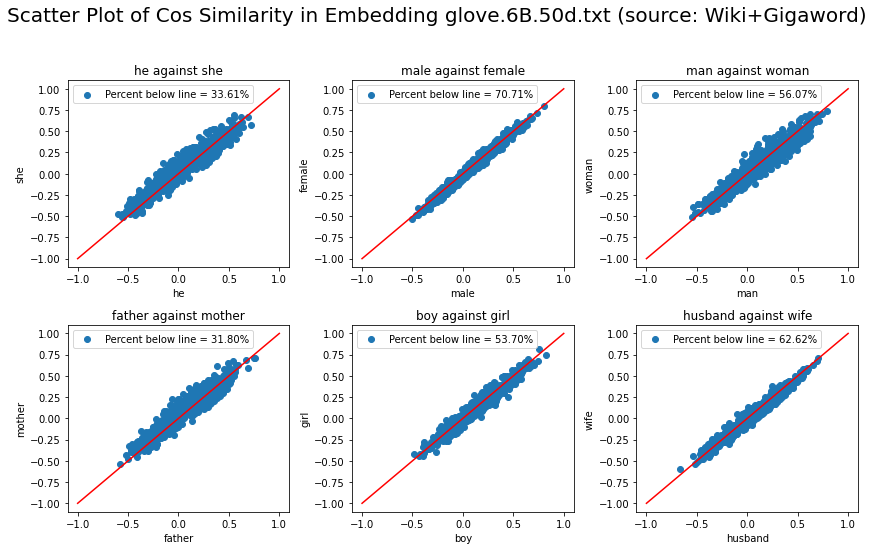

Embedding file glove.6B.100d.txt vocabulary size: 400000
original words: 1383, in vocab words: 717


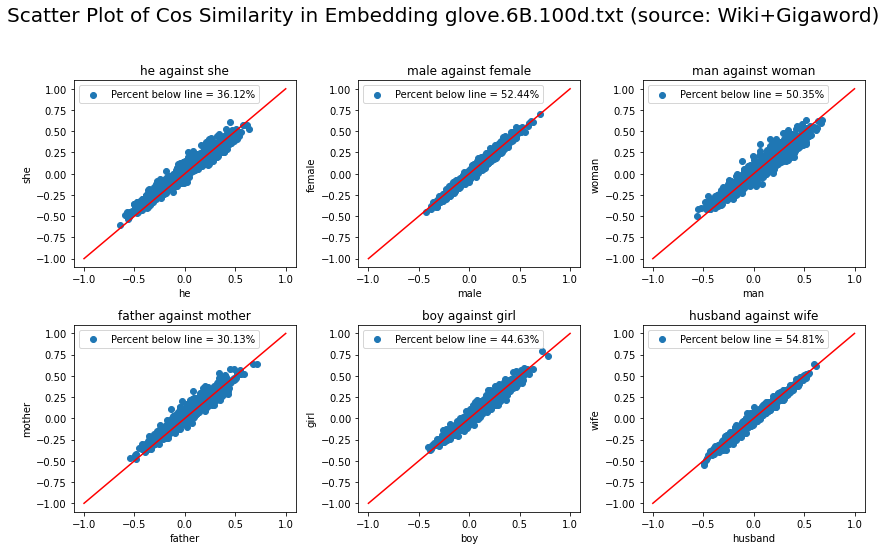

Embedding file glove.6B.300d.txt vocabulary size: 400000
original words: 1383, in vocab words: 717


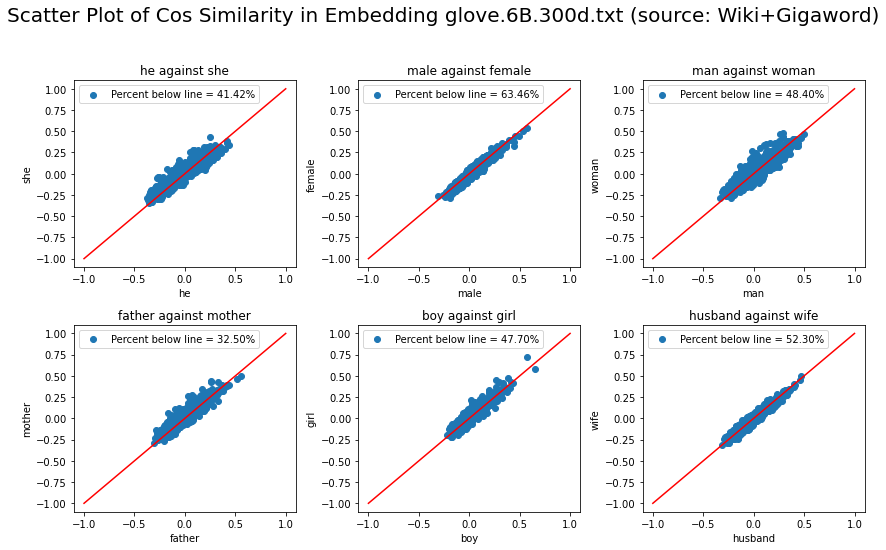

Embedding file glove.6B.200d.txt vocabulary size: 400000
original words: 1383, in vocab words: 717


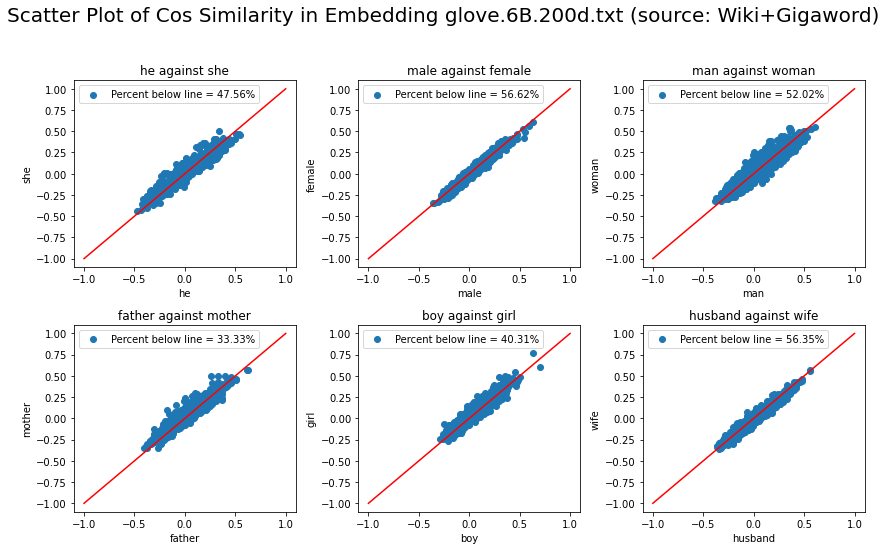

In [24]:
plot_scatter_from_source(source='6B')

Embedding file glove.42B.300d.txt vocabulary size: 1917494
original words: 1383, in vocab words: 1019


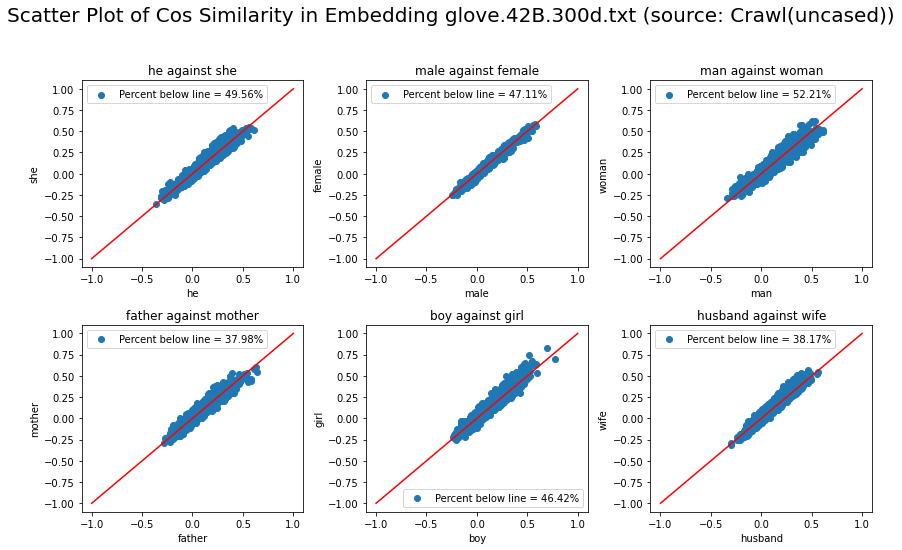

Embedding file glove.840B.300d.txt vocabulary size: 2196016
original words: 1383, in vocab words: 966


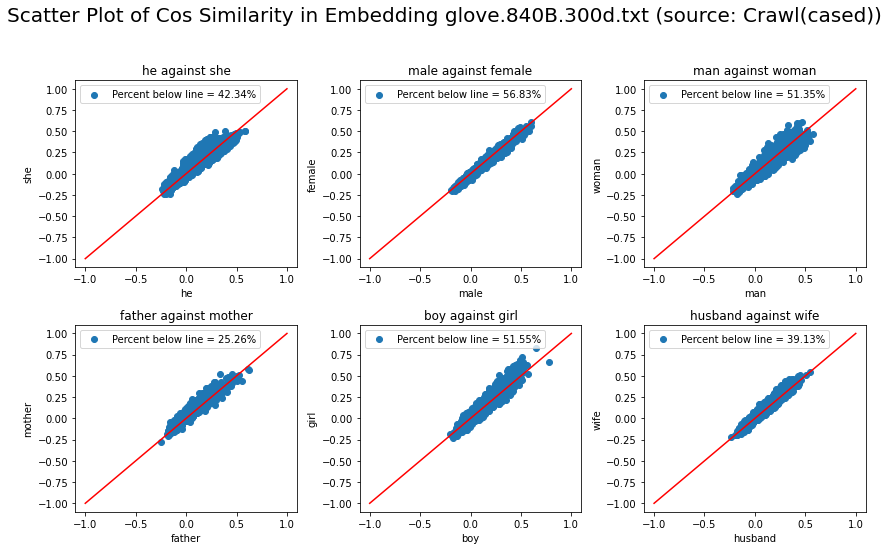

In [25]:
plot_scatter_from_source(source='42B')
plot_scatter_from_source(source='840B')

Embedding file glove.twitter.27B.100d.txt vocabulary size: 1193514
original words: 1383, in vocab words: 912


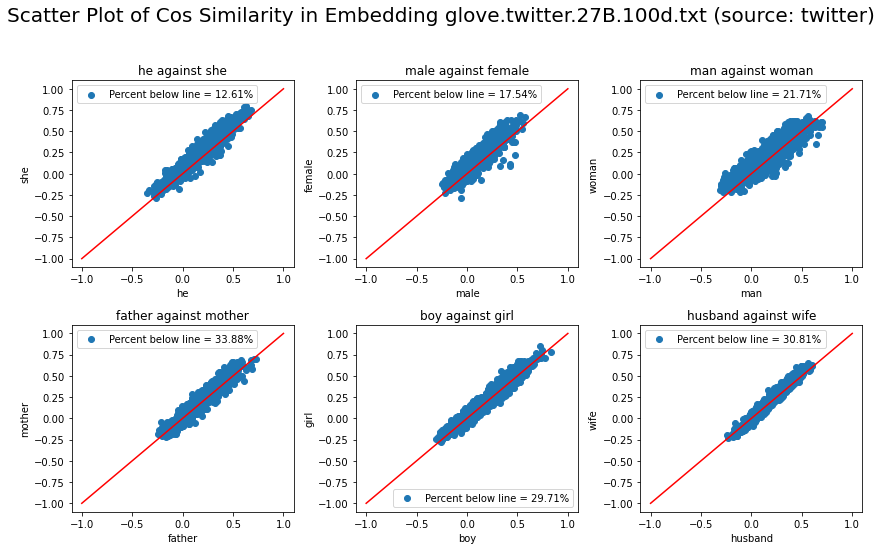

Embedding file glove.twitter.27B.50d.txt vocabulary size: 1193514
original words: 1383, in vocab words: 912


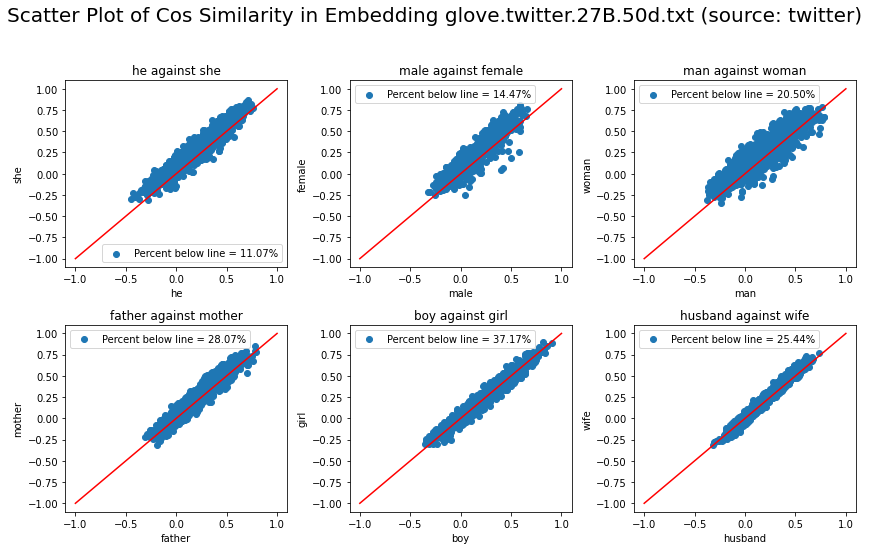

Embedding file glove.twitter.27B.25d.txt vocabulary size: 1193514
original words: 1383, in vocab words: 912


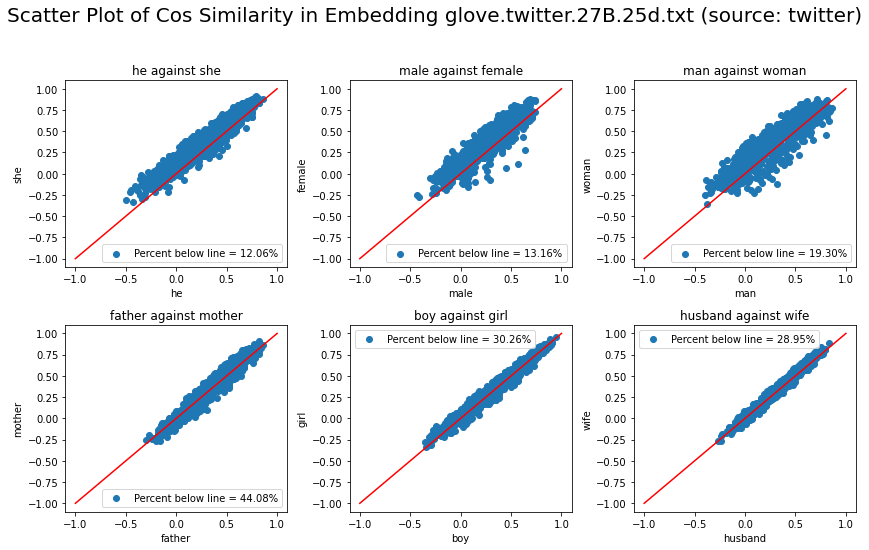

Embedding file glove.twitter.27B.200d.txt vocabulary size: 1193514
original words: 1383, in vocab words: 912


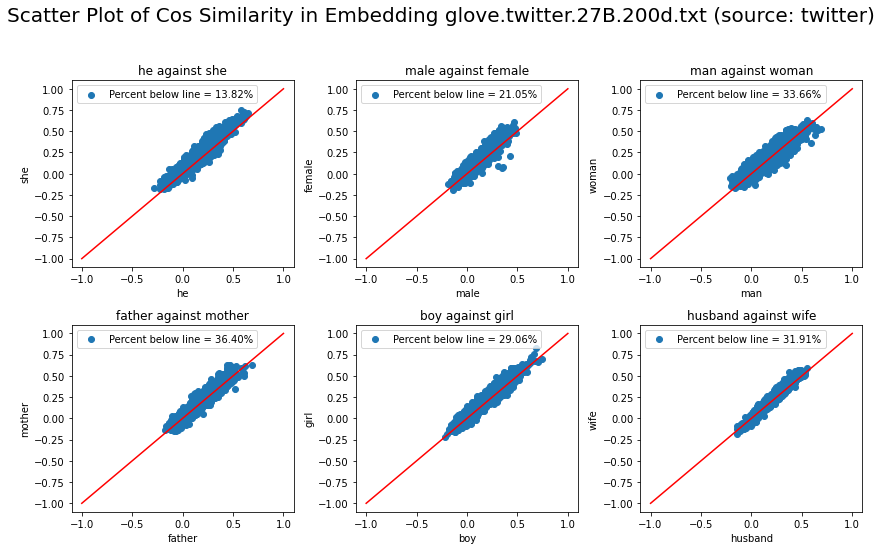

In [26]:
plot_scatter_from_source(source='twitter')

In [ ]:
def interactive_plot(embedding_file, m, f):
    embedding = read_embedding_file(embedding_file)
    bad_words_invocab = filter_vocab(embedding, bad_words)
    x, y = scatter_bad_words(m, f, embedding, bad_words_invocab)
    fig = px.scatter(x, y, x=m, y=f, color = x-y)
    fig.show()

### ELMO - contextual embedding

Embeddings from a language model trained on the [1 Billion Word Benchmark](https://arxiv.org/pdf/1312.3005.pdf).

Result: In deeper layers, more biases start to appear as lstms embed more contextual information.

In [30]:
elmo = hub.load("https://tfhub.dev/google/elmo/3")
def get_elmo_embedding(sentences):
    embeddings = elmo.signatures["default"](tf.constant(sentences))
    return embeddings['word_emb'], embeddings['lstm_outputs1'], embeddings['lstm_outputs2']

In [51]:
embedding_word = {}
embedding_lstm1 = {}
embedding_lstm2 = {}
def elmo2dict(words):
    word_emb, lstm1_emb, lstm2_emb = get_elmo_embedding(words)
    word_emb = word_emb.numpy()
    lstm1_emb = lstm1_emb.numpy()
    lstm2_emb = lstm2_emb.numpy()
    for i,word in enumerate(words):
        embedding_word[word] = word_emb[i,0,:]
        embedding_lstm1[word] = lstm1_emb[i,0,:]
        embedding_lstm2[word] = lstm2_emb[i,0,:]
elmo2dict(male_words+female_words+bad_words)

In [52]:
def cos_similarity(w1, w2, embedding):
    try:
        e1 = embedding[w1]
        e2 = embedding[w2]
        return (e1*e2).sum()/np.sqrt((e1*e1).sum()*(e2*e2).sum())
    except:
        for w in [w1, w2]:
            if w not in embedding.keys():
                print(f"{w} not in vocab")
        return 0

def scatter_bad_words(m, f, embedding, bad_words_invocab):
    x = [cos_similarity(w, m, embedding) for w in bad_words_invocab]
    y = [cos_similarity(w, f, embedding) for w in bad_words_invocab]
    return x, y

def plot_bad_words(m, f, ax, embedding, bad_words_invocab):
    x, y = scatter_bad_words(m, f, embedding, bad_words_invocab)
    ax.scatter(x, y, label = f'Percent below line = {(np.array(x)>np.array(y)).mean():.2%}')
    ax.plot([-1,1],[-1,1], color='red')
    ax.set_xlabel(m)
    ax.set_ylabel(f)
    ax.set_title(f"{m} against {f}")
    ax.legend()
    
def plot_scatter(embedding, bad_words_invocab, embedding_file):
    fig, ax = plt.subplots(2,3,figsize=(12,8))
    for i,(m,f) in enumerate(zip(male_words, female_words)):
        plot_bad_words(m, f, ax[i//3, i%3], embedding, bad_words_invocab)
    fig.suptitle(f"Scatter Plot of Cos Similarity in Embedding {embedding_file}", fontsize=20)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

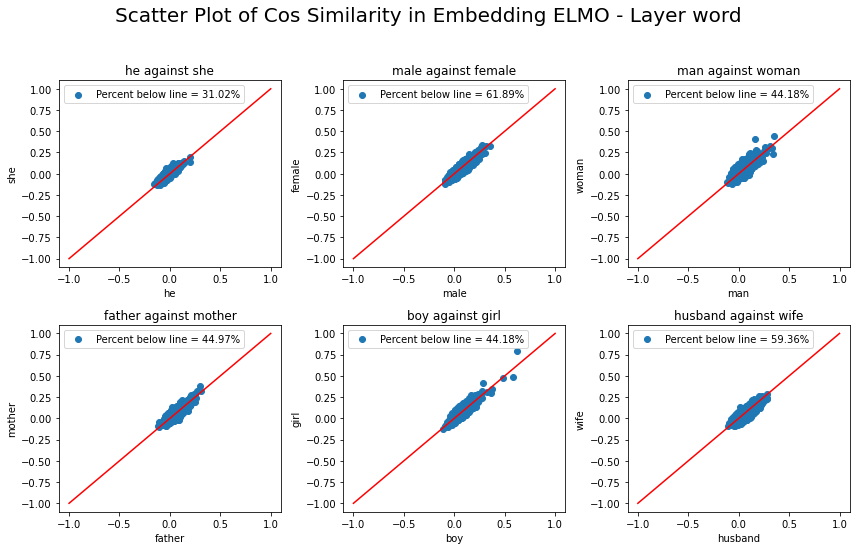

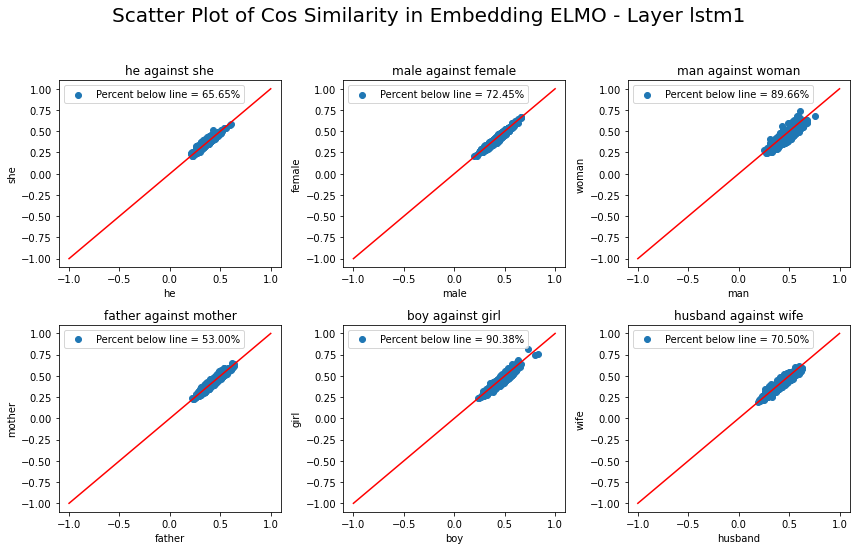

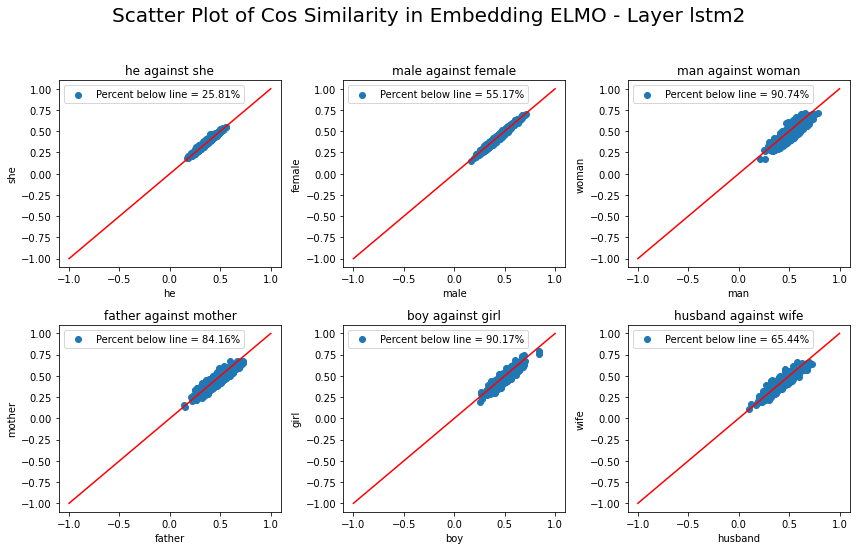

In [54]:
for embedding, layer in zip([embedding_word, embedding_lstm1, embedding_lstm2],['word', 'lstm1', 'lstm2']):
    plot_scatter(embedding, bad_words, f"ELMO - Layer {layer}")